# Vehicle detection using support vector machines
#### The goals / steps of this project are the following:

- Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
- Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
- Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
- Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
- Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
    Estimate a bounding box for vehicles detected.


## import and data set exploration

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
from mpl_toolkits.mplot3d import Axes3D
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
# NOTE: the next import is only valid 
# for scikit-learn version <= 0.17
# if you are using scikit-learn >= 0.18 then use this:
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split
import time

# import vehicle pictures
# downloaded from udacity

notcars=glob.glob('non-vehicles/**/*.png')
cars   =glob.glob(    'vehicles/**/*.png')

def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    # Define a key "image_shape" and store the test image shape 3-tuple
    example_img = mpimg.imread(car_list[0])
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict
    
data_info = data_look(cars, notcars)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])



# Plot some random examples
fig, axs = plt.subplots(4,4, figsize=(16, 16))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

for i in np.arange(0,8):
    img = mpimg.imread(cars[np.random.randint(0,len(cars))]) #RGB
    axs[i].axis('off')
    axs[i].set_title('car')
    axs[i].imshow(img)
for i in np.arange(8,16):
    img = mpimg.imread(notcars[np.random.randint(0,len(notcars))]) #RGB
    axs[i].axis('off')
    axs[i].set_title('notcar')
    axs[i].imshow(img)

Your function returned a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: float32


# binary spatial of an image

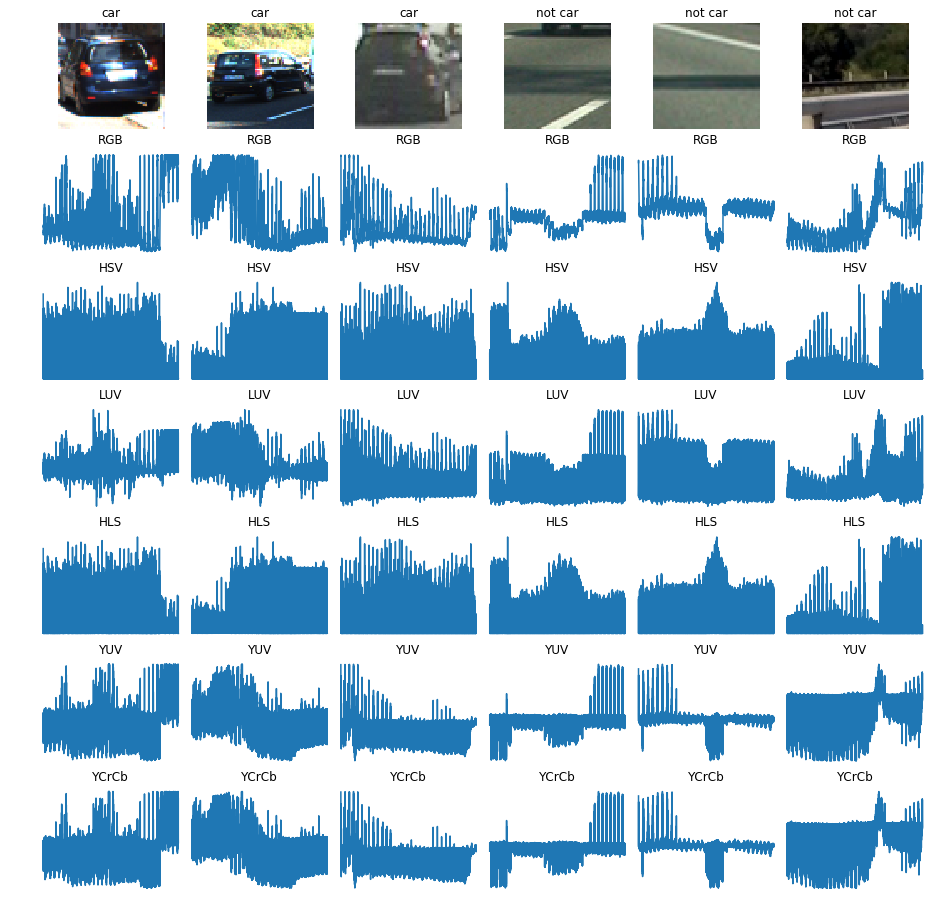

In [2]:
image = mpimg.imread('car_pictures/cutout1.jpg')

# Define a function to compute color histogram features  
# Pass the color_space flag as 3-letter all caps string
# like 'HSV' or 'LUV' etc.
# KEEP IN MIND IF YOU DECIDE TO USE THIS FUNCTION LATER
# IN YOUR PROJECT THAT IF YOU READ THE IMAGE WITH 
# cv2.imread() INSTEAD YOU START WITH BGR COLOR!
def bin_spatial(img, color_space='RGB', size=(32, 32)):
    # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)             
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel() 
    # Return the feature vector
    return features
    

# Plot some random examples
columns=6
colors=['RGB','HSV','LUV','HLS','YUV','YCrCb']
fig, axs = plt.subplots(len(colors)+1,columns, figsize=(16, 16))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

# explore the color spaces
for i in np.arange(0,columns):
    if i<int(columns/2):
        img = mpimg.imread(cars[np.random.randint(0,len(cars))]) #RGB
        desc='car'
    else:
        img = mpimg.imread(notcars[np.random.randint(0,len(notcars))]) #RGB
        desc='not car'
    axs[i].axis('off')
    axs[i].set_title(desc)
    axs[i].imshow(img)
    
    #go through colors
    for j in range(len(colors)):
        axs[i+columns*(j+1)].axis('off')
        axs[i+columns*(j+1)].set_title(colors[j])
        axs[i+columns*(j+1)].plot(bin_spatial(img, color_space=colors[j], size=(32,32)))
    


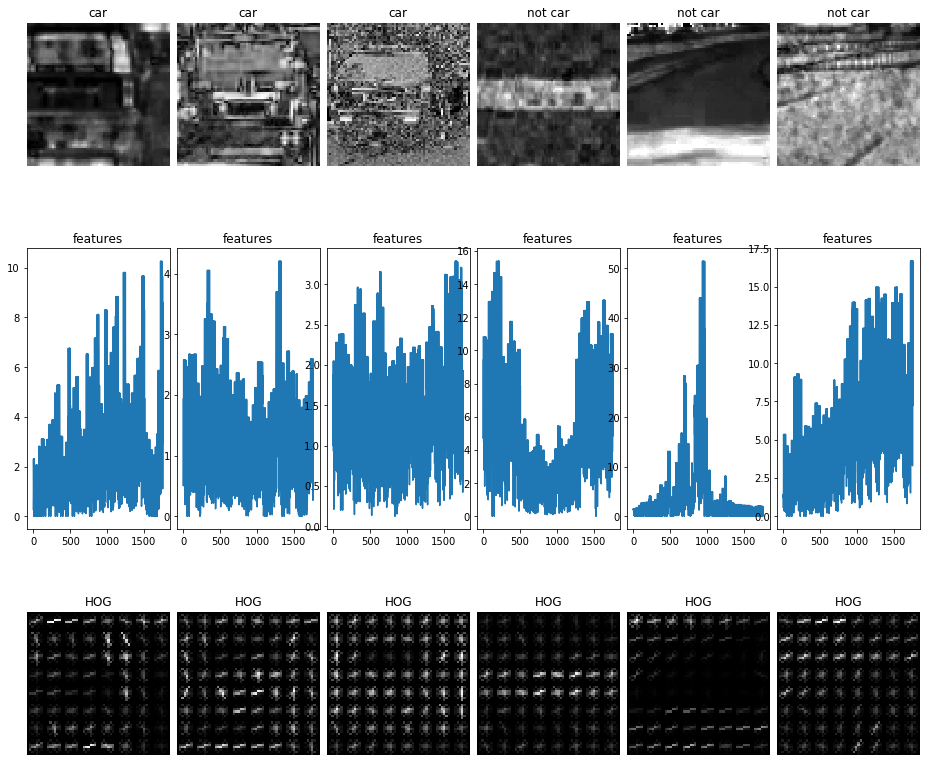

In [3]:

# Define a function to return HOG features and visualization
# Features will always be the first element of the return
# Image data will be returned as the second element if visualize= True
# Otherwise there is no second return element
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=True, 
                     feature_vec=True):

    hog_features, hog_image = hog(img, orientations=orient,
                          pixels_per_cell=(pix_per_cell, pix_per_cell), 
                          cells_per_block=(cell_per_block, cell_per_block), 
                          visualise=vis, feature_vector=feature_vec,
                          block_norm="L2-Hys") 
    # TODO: Complete the function body and returns
    return hog_features,hog_image



# Plot some random examples
columns=6
fig, axs = plt.subplots(3,columns, figsize=(16, 16))
fig.subplots_adjust(hspace = .05, wspace=.05)
axs = axs.ravel()

# explore HOG on cars
for i in np.arange(0,columns):
    if i<int(columns/2):
        img = mpimg.imread(cars[np.random.randint(0,len(cars))]) #RGB
        desc='car'
    else:
        img = mpimg.imread(notcars[np.random.randint(0,len(notcars))]) #RGB
        desc='not car'
    HSV=cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    axs[i].axis('off')
    axs[i].set_title(desc)
    axs[i].imshow(HSV[:,:,1], cmap='gray')
    
    #get hog of HSV transfomed image
    features, hog_image = get_hog_features(HSV[:,:,1], orient= 9, 
                        pix_per_cell= 8, cell_per_block= 2, 
                        vis=True, feature_vec=True)    
    axs[i+columns].set_title('features')
    axs[i+columns].plot(features)
    
    axs[i+columns*2].axis('off')
    axs[i+columns*2].set_title('HOG')
    axs[i+columns*2].imshow(hog_image, cmap='gray')



## Performance comparison of different color spaces

In [25]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
            elif cspace == 'LAB':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        else: feature_image = np.copy(image)      
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features)))
    # Return list of feature vectors
    return features


cspaces=['RGB','RGB','HSV','HSV','LUV','LUV','HLS','HLS','YUV','YUV','YCrCb','YCrCb','LAB','LAB']
cspaces=['LUV']
spatials = [4,8,12,16,20,24,32]
histbins = [4,8,12,16,20,24,32]
print('extraction started')
for cspace in cspaces:
    for spatial in spatials:
        for histbin in histbins:
            print('.')
            print('.')
            ts_extract=time.time()
            car_features = extract_features(cars, cspace=cspace, spatial_size=(spatial, spatial),
                                hist_bins=histbin, hist_range=(0, 256))
            notcar_features = extract_features(notcars, cspace=cspace, spatial_size=(spatial, spatial),
                                hist_bins=histbin, hist_range=(0, 256))
            te_extract=time.time()
            # Create an array stack of feature vectors
            X = np.vstack((car_features, notcar_features)).astype(np.float64)

            # Define the labels vector
            y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

            # Split up data into randomized training and test sets
            rand_state = np.random.randint(0, 100)
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.2, random_state=rand_state)

            # Fit a per-column scaler only on the training data
            X_scaler = StandardScaler().fit(X_train)
            # Apply the scaler to X_train and X_test
            X_train = X_scaler.transform(X_train)
            X_test = X_scaler.transform(X_test)

            print('Using spatial binning of:',spatial,'and', histbin,'histogram bins')
            print('Feature vector length:', len(X_train[0]))
            # Use a linear SVC 
            svc = LinearSVC()
            # Check the training time for the SVC
            tt=time.time()
            svc.fit(X_train, y_train)
            tt2 = time.time()
            print(round(tt2-tt, 2), 'Seconds to train SVC...')
            # Check the score of the SVC
            print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
            # Check the prediction time for a single sample
            tp=time.time()
            n_predict = 10
            print('Color space: ',cspace)
            print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
            print('For these',n_predict, 'labels: ', y_test[0:n_predict])
            tp2 = time.time()
            print(round(tp2-tp, 5), 'Seconds to predict', n_predict,'labels with SVC')
            print('|',cspace,'|',
                  spatial,',',histbin,'|',
                  round(tt2-tt, 2),'|', 
                  len(X_train), '|',
                  round(tp2-tp, 5),'|',
                  round(svc.score(X_test, y_test), 4),'|')

extraction started
.
.
Using spatial binning of: 4 and 4 histogram bins
Feature vector length: 60
3.23 Seconds to train SVC...
Test Accuracy of SVC =  0.8466
Color space:  LUV
My SVC predicts:  [ 0.  0.  0.  0.  0.  1.  0.  1.  0.  1.]
For these 10 labels:  [ 0.  0.  0.  0.  1.  1.  0.  1.  1.  1.]
0.00249 Seconds to predict 10 labels with SVC
| LUV | 4 , 4 | 3.23 | 14208 | 0.00249 | 0.8466 |
.
.
Using spatial binning of: 4 and 8 histogram bins
Feature vector length: 72
2.46 Seconds to train SVC...
Test Accuracy of SVC =  0.9068
Color space:  LUV
My SVC predicts:  [ 1.  0.  0.  1.  0.  0.  1.  1.  1.  1.]
For these 10 labels:  [ 1.  1.  0.  1.  0.  0.  1.  1.  1.  1.]
0.00201 Seconds to predict 10 labels with SVC
| LUV | 4 , 8 | 2.46 | 14208 | 0.00201 | 0.9068 |
.
.
Using spatial binning of: 4 and 12 histogram bins
Feature vector length: 84
2.72 Seconds to train SVC...
Test Accuracy of SVC =  0.9248
Color space:  LUV
My SVC predicts:  [ 0.  0.  1.  1.  1.  0.  1.  1.  0.  0.]
For these

Using spatial binning of: 16 and 8 histogram bins
Feature vector length: 792
10.48 Seconds to train SVC...
Test Accuracy of SVC =  0.942
Color space:  LUV
My SVC predicts:  [ 0.  0.  0.  1.  1.  1.  1.  0.  0.  0.]
For these 10 labels:  [ 0.  0.  0.  1.  1.  1.  1.  0.  0.  0.]
0.00251 Seconds to predict 10 labels with SVC
| LUV | 16 , 8 | 10.48 | 14208 | 0.00251 | 0.942 |
.
.
Using spatial binning of: 16 and 12 histogram bins
Feature vector length: 804
10.12 Seconds to train SVC...
Test Accuracy of SVC =  0.9555
Color space:  LUV
My SVC predicts:  [ 0.  0.  1.  1.  1.  1.  0.  1.  0.  0.]
For these 10 labels:  [ 0.  0.  1.  1.  1.  1.  1.  1.  0.  0.]
0.0015 Seconds to predict 10 labels with SVC
| LUV | 16 , 12 | 10.12 | 14208 | 0.0015 | 0.9555 |
.
.
Using spatial binning of: 16 and 16 histogram bins
Feature vector length: 816
10.09 Seconds to train SVC...
Test Accuracy of SVC =  0.9513
Color space:  LUV
My SVC predicts:  [ 1.  1.  0.  1.  0.  1.  0.  1.  1.  0.]
For these 10 labels: 

Using spatial binning of: 32 and 12 histogram bins
Feature vector length: 3108
26.65 Seconds to train SVC...
Test Accuracy of SVC =  0.9251
Color space:  LUV
My SVC predicts:  [ 0.  1.  0.  0.  1.  1.  0.  1.  0.  0.]
For these 10 labels:  [ 0.  1.  0.  0.  1.  1.  0.  1.  0.  0.]
0.01404 Seconds to predict 10 labels with SVC
| LUV | 32 , 12 | 26.65 | 14208 | 0.01404 | 0.9251 |
.
.
Using spatial binning of: 32 and 16 histogram bins
Feature vector length: 3120
26.46 Seconds to train SVC...
Test Accuracy of SVC =  0.9271
Color space:  LUV
My SVC predicts:  [ 1.  0.  0.  0.  1.  0.  0.  1.  1.  0.]
For these 10 labels:  [ 1.  0.  0.  0.  1.  0.  0.  1.  1.  0.]
0.01554 Seconds to predict 10 labels with SVC
| LUV | 32 , 16 | 26.46 | 14208 | 0.01554 | 0.9271 |
.
.
Using spatial binning of: 32 and 20 histogram bins
Feature vector length: 3132
26.6 Seconds to train SVC...
Test Accuracy of SVC =  0.9322
Color space:  LUV
My SVC predicts:  [ 0.  0.  1.  1.  1.  0.  1.  1.  1.  0.]
For these 10 

| Color space | Spatial, hist   | Training duration s | Training samples | Prediction time | Accuracy % |
|-------------|-----------------|---------------------|------------------|-----------------|------------|
| RGB | 32 , 32 | 47.94 | 14208 | 0.00451 | 0.9079 |
| RGB | 32 , 32 | 47.06 | 14208 | 0.01354 | 0.9091 |
| HSV | 32 , 32 | 30.11 | 14208 | 0.01351 | 0.9032 |
| HSV | 32 , 32 | 28.31 | 14208 | 0.00501 | 0.8919 |
| LUV | 32 , 32 | 24.55 | 14208 | 0.00853 | 0.9361 |
| LUV | 32 , 32 | 21.68 | 14208 | 0.00852 | 0.9372 |
| HLS | 32 , 32 | 25.71 | 14208 | 0.00501 | 0.9071 |
| HLS | 32 , 32 | 25.32 | 14208 | 0.00802 | 0.904 |
| YUV | 32 , 32 | 33.31 | 14208 | 0.00251 | 0.911 |
| YUV | 32 , 32 | 33.96 | 14208 | 0.01153 | 0.8978 |
| YCrCb | 32 , 32 | 0.14 | 14208 | 0.00904 | 0.4952 |
| YCrCb | 32 , 32 | 0.14 | 14208 | 0.02106 | 0.5011 |
| LAB | 32 , 32 | 0.14 | 14208 | 0.0 | 0.5068 |
| LAB | 32 , 32 | 0.14 | 14208 | 0.00953 | 0.5011 |
| RGB | 16 , 16 | 17.2 | 14208 | 0.00302 | 0.9305 |
| RGB | 16 , 16 | 16.59 | 14208 | 0.002 | 0.9257 |
| HSV | 16 , 16 | 16.28 | 14208 | 0.00251 | 0.9093 |
| HSV | 16 , 16 | 15.68 | 14208 | 0.00251 | 0.911 |
| LUV | 16 , 16 | 10.46 | 14208 | 0.00201 | 0.9485 |
| LUV | 16 , 16 | 10.4 | 14208 | 0.00201 | 0.9409 |
| HLS | 16 , 16 | 16.33 | 14208 | 0.00201 | 0.9133 |
| HLS | 16 , 16 | 15.75 | 14208 | 0.00201 | 0.9136 |
| YUV | 16 , 16 | 15.5 | 14208 | 0.00251 | 0.9251 |
| YUV | 16 , 16 | 15.77 | 14208 | 0.00201 | 0.9206 |
| YCrCb | 16 , 16 | 0.05 | 14208 | 0.0015 | 0.5011 |
| YCrCb | 16 , 16 | 0.05 | 14208 | 0.00201 | 0.5149 |
| LAB | 16 , 16 | 0.05 | 14208 | 0.0015 | 0.5059 |
| LAB | 16 , 16 | 0.05 | 14208 | 0.00351 | 0.5011 |
| LUV | 4 , 4 | 3.23 | 14208 | 0.00249 | 0.8466 |
| LUV | 4 , 8 | 2.46 | 14208 | 0.00201 | 0.9068 |
| LUV | 4 , 12 | 2.72 | 14208 | 0.0015 | 0.9248 |
| LUV | 4 , 16 | 2.84 | 14208 | 0.0015 | 0.9206 |
| LUV | 4 , 20 | 2.48 | 14208 | 0.002 | 0.9254 |
| LUV | 4 , 24 | 3.15 | 14208 | 0.00101 | 0.9265 |
| LUV | 4 , 32 | 3.1 | 14208 | 0.001 | 0.926 |
| LUV | 8 , 4 | 5.53 | 14208 | 0.001 | 0.9133 |
| LUV | 8 , 8 | 4.55 | 14208 | 0.00201 | 0.9423 |
| LUV | 8 , 12 | 4.53 | 14208 | 0.002 | 0.9437 |
| LUV | 8 , 16 | 4.91 | 14208 | 0.00201 | 0.9488 |
| LUV | 8 , 20 | 4.62 | 14208 | 0.00201 | 0.9558 |
| LUV | 8 , 24 | 4.31 | 14208 | 0.00201 | 0.9513 |
| LUV | 8 , 32 | 4.38 | 14208 | 0.00201 | 0.9521 |
| LUV | 12 , 4 | 10.11 | 14208 | 0.00149 | 0.9307 |
| LUV | 12 , 8 | 8.0 | 14208 | 0.00152 | 0.949 |
| LUV | 12 , 12 | 7.97 | 14208 | 0.0015 | 0.9524 |
| LUV | 12 , 16 | 7.23 | 14208 | 0.0015 | 0.9516 |
| LUV | 12 , 20 | 7.24 | 14208 | 0.0015 | 0.9569 |
| LUV | 12 , 24 | 7.0 | 14208 | 0.00201 | 0.9589 |
| LUV | 12 , 32 | 6.45 | 14208 | 0.0015 | 0.9533 |
| LUV | 16 , 4 | 13.35 | 14208 | 0.0015 | 0.9316 |
| LUV | 16 , 8 | 10.48 | 14208 | 0.00251 | 0.942 |
| LUV | 16 , 12 | 10.12 | 14208 | 0.0015 | 0.9555 |
| LUV | 16 , 16 | 10.09 | 14208 | 0.00301 | 0.9513 |
| LUV | 16 , 20 | 9.3 | 14208 | 0.00201 | 0.9474 |
| LUV | 16 , 24 | 8.51 | 14208 | 0.00199 | 0.9521 |
| LUV | 16 , 32 | 8.3 | 14208 | 0.00201 | 0.9606 |
| LUV | 20 , 4 | 17.0 | 14208 | 0.002 | 0.9282 |
| LUV | 20 , 8 | 10.9 | 14208 | 0.00251 | 0.9305 |
| LUV | 20 , 12 | 11.08 | 14208 | 0.00451 | 0.9299 |
| LUV | 20 , 16 | 10.1 | 14208 | 0.00201 | 0.9268 |
| LUV | 20 , 20 | 10.51 | 14208 | 0.00501 | 0.9369 |
| LUV | 20 , 24 | 8.99 | 14208 | 0.00251 | 0.9395 |
| LUV | 20 , 32 | 9.14 | 14208 | 0.00251 | 0.9417 |
| LUV | 24 , 4 | 18.65 | 14208 | 0.00251 | 0.9071 |
| LUV | 24 , 8 | 14.97 | 14208 | 0.00351 | 0.9212 |
| LUV | 24 , 12 | 14.74 | 14208 | 0.0015 | 0.9288 |
| LUV | 24 , 16 | 13.3 | 14208 | 0.00201 | 0.924 |
| LUV | 24 , 20 | 14.05 | 14208 | 0.00352 | 0.9268 |
| LUV | 24 , 24 | 13.15 | 14208 | 0.00251 | 0.9316 |
| LUV | 24 , 32 | 11.31 | 14208 | 0.00201 | 0.9333 |
| LUV | 32 , 4 | 30.35 | 14208 | 0.01955 | 0.9068 |
| LUV | 32 , 8 | 29.81 | 14208 | 0.00953 | 0.9271 |
| LUV | 32 , 12 | 26.65 | 14208 | 0.01404 | 0.9251 |
| LUV | 32 , 16 | 26.46 | 14208 | 0.01554 | 0.9271 |
| LUV | 32 , 20 | 26.6 | 14208 | 0.02106 | 0.9322 |
| LUV | 32 , 24 | 24.79 | 14208 | 0.00501 | 0.9299 |
| LUV | 32 , 32 | 24.46 | 14208 | 0.00803 | 0.9392 |


Decision for LUV because of precision and a reasonable classification time
It's even better using 16/16
Further exploration of the space only for LUV
LUV 16/32 chosen to be best, or 8/20 to be double the speed for half the computational effort 

Small deviations from usage of the laptop possible. 

## HOG comparison of different color spaces

In [3]:
print('run')
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
            elif cspace == 'LAB':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features


# Reduce the sample size because HOG features are slow to compute
np.random.shuffle(cars)
np.random.shuffle(notcars)
#sample_size = 50
#cars = cars[0:sample_size]
#notcars = notcars[0:sample_size]

### TODO: Tweak these parameters and see how the results change.
colorspaces = ['RGB','HSV','LUV','HLS','YUV','YCrCb','LAB']
colorspaces = ['LUV','YUV','LAB']
color_channel = [['HSV', 'ALL'], ['HLS','ALL'],['YCrCb','ALL'], ['YCrCb',0],['YUV',1]]
orients = [3,9,12]
pix_per_cells = [4,8,16]
cell_per_block = 2
hog_channels = ['ALL'] # Can be 0, 1, 2, or "ALL"


winning_combination=[['HSV',   'ALL', 3, 16],
                    ['HSV',   'ALL', 9, 16],
                    ['HLS',   'ALL', 3, 16], 
                    ['HLS',   'ALL', 9, 16], 
                    ['YCrCb', 'ALL', 3, 4], 
                    ['YCrCb', 'ALL', 3, 8], 
                    ['YCrCb', 'ALL', 3, 16], 
                    ['YCrCb', 'ALL', 9, 4], 
                    ['YCrCb', 'ALL', 9, 8], 
                    ['YCrCb', 'ALL', 9, 16], 
                    ['YCrCb', 'ALL', 12, 4], 
                    ['YCrCb', 'ALL', 12, 8], 
                    ['YCrCb', 'ALL', 12, 16], 
                    ['YCrCb', 0,  9, 16], 
                    ['YCrCb', 0,  9, 16], 
                    ['YCrCb', 0,  12, 16], 
                    ['YUV',   1, 3, 16],
                    ['YUV',   1, 12, 4]]
winning_combination=[['YCrCb', 'ALL', 12, 8], 
                    ['YCrCb', 'ALL', 12, 16], 
                    ['YCrCb', 0,  9, 16], 
                    ['YCrCb', 0,  9, 16], 
                    ['YCrCb', 0,  12, 16], 
                    ['YUV',   1, 3, 16],
                    ['YUV',   1, 12, 4]]
#Here are several options to run this function
#Loop for exploring colorspaces and channels:
#for colorspace in colorspaces:
#    for hog_channel in hog_channels:

#for colorspace, hog_channel in color_channel:
#    for orient in orients:
#        for pix_per_cell in pix_per_cells:
for colorspace, hog_channel, orient, pix_per_cell in winning_combination:
            print('...')
            print('...')
            te=time.time()
            car_features = extract_features(cars, cspace=colorspace, orient=orient, 
                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                            hog_channel=hog_channel)
            notcar_features = extract_features(notcars, cspace=colorspace, orient=orient, 
                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                            hog_channel=hog_channel)
            te2 = time.time()
            print(round(te2-te, 2), 'Seconds to extract HOG features...')

            # Create an array stack of feature vectors
            X = np.vstack((car_features, notcar_features)).astype(np.float64)
            
            # Define the labels vector
            y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

            # Split up data into randomized training and test sets
            rand_state = np.random.randint(0, 100)
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.2, random_state=rand_state)

            # Fit a per-column scaler
            X_scaler = StandardScaler().fit(X_train)
            # Apply the scaler to X
            X_train = X_scaler.transform(X_train)
            X_test = X_scaler.transform(X_test)

            print('Using:',orient,'orientations',pix_per_cell,
                'pixels per cell and', cell_per_block,'cells per block')
            print('Feature vector length:', len(X_train[0]))
            # Use a linear SVC 
            svc = LinearSVC()
            # Check the training time for the SVC
            tt=time.time()
            svc.fit(X_train, y_train)
            tt2 = time.time()
            print(round(tt2-tt, 2), 'Seconds to train SVC...')
            # Check the score of the SVC
            print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
            # Check the prediction time for a single sample
            tp=time.time()
            n_predict = 10
            print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
            print('For these',n_predict, 'labels: ', y_test[0:n_predict])
            tp2 = time.time()
            #print(round(tp2-tp, 5), 'Seconds to predict', n_predict,'labels with SVC')

            print('|',colorspace,'|',
                 hog_channel,'|',
                 orient, '|',
                 pix_per_cell,'|',
                 cell_per_block, '|',
                 len(X_train[0]),'|',
                 round(te2-te, 2),'|',
                 round(tt2-tt, 2),'|',
                 round(tp2-tp, 5),'|',
                 round(svc.score(X_test, y_test), 4),'|')

run
...
...
115.06 Seconds to extract HOG features...
Using: 12 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 7056
36.26 Seconds to train SVC...
Test Accuracy of SVC =  0.9651
My SVC predicts:  [ 0.  0.  1.  0.  0.  1.  0.  1.  1.  0.]
For these 10 labels:  [ 0.  0.  1.  0.  0.  1.  0.  1.  1.  0.]
| YCrCb | ALL | 12 | 8 | 2 | 7056 | 115.06 | 36.26 | 0.00551 | 0.9651 |
...
...
60.63 Seconds to extract HOG features...
Using: 12 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 1296
4.3 Seconds to train SVC...
Test Accuracy of SVC =  0.9792
My SVC predicts:  [ 0.  0.  0.  1.  0.  0.  1.  1.  1.  0.]
For these 10 labels:  [ 0.  0.  0.  1.  0.  0.  1.  1.  1.  0.]
| YCrCb | ALL | 12 | 16 | 2 | 1296 | 60.63 | 4.3 | 0.00251 | 0.9792 |
...
...
26.58 Seconds to extract HOG features...
Using: 9 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 324
5.91 Seconds to train SVC...
Test Accuracy of SVC =  0.9426
My SV

### HOG parameter search

Some of the color-channels produced ValueError: Input contains NaN, infinity or a value too large for dtype('float64').
So, they are excluded from the scope of this review. Assuming the color has points without gradients in some of the 16000 pictures, it's probably not a good color space anyway. 

Afterwards, the following combinations are chosen to be of interest: HSV / ALL, HLS / ALL, YCrCb / ALL and LAB / 0, YCrCB / 0, 1, YUV 1. Those are explored in detail. 

|Colorspace|HOG-Channel|Orientations|Pixel per Cell|Cell per Block|Feature vector length|Extraction Duration|Training duration|Prediction Duration|Accuracy
|----------|------------|--------------|--------------|-----------|---------------------|-------------------|-----------------|---------------|---------|
| RGB | 0 | 9 | 8 | 2 | 1764 | 47.8 | 26.2 | 0.00451 | 0.9037 |
| RGB | 1 | 9 | 8 | 2 | 1764 | 48.35 | 19.06 | 0.00251 | 0.9186 |
| RGB | 2 | 9 | 8 | 2 | 1764 | 49.43 | 18.28 | 0.00247 | 0.9068 |
| RGB | ALL | 9 | 8 | 2 | 5292 | 134.74 | 43.56 | 0.00752 | 0.9237 |
| HSV | 0 | 9 | 8 | 2 | 1764 | 54.51 | 29.03 | 0.00201 | 0.8908 |
| HSV | 1 | 9 | 8 | 2 | 1764 | 44.77 | 25.47 | 0.00201 | 0.913 |
| HSV | 2 | 9 | 8 | 2 | 1764 | 46.28 | 17.91 | 0.00202 | 0.913 |
| HSV | ALL | 9 | 8 | 2 | 5292 | 129.46 | 30.37 | 0.00301 | 0.96 |
| LUV | 0 | 9 | 8 | 2 | 1764 | 54.18 | 17.93 | 0.0015 | 0.9153 |
| HLS | 0 | 9 | 8 | 2 | 1764 | 48.52 | 29.88 | 0.004 | 0.8891 |
| HLS | 1 | 9 | 8 | 2 | 1764 | 48.37 | 20.39 | 0.00301 | 0.9071 |
| HLS | 2 | 9 | 8 | 2 | 1764 | 49.98 | 28.79 | 0.0015 | 0.904 |
| HLS | ALL | 9 | 8 | 2 | 5292 | 137.89 | 33.38 | 0.00401 | 0.9569 |
| YUV | 0 | 9 | 8 | 2 | 1764 | 56.21 | 18.48 | 0.00201 | 0.9181 |
| YUV | 1 | 9 | 8 | 2 | 1764 | 46.14 | 16.71 | 0.00199 | 0.9243 |
| YCrCb | 0 | 9 | 8 | 2 | 1764 | 45.29 | 18.17 | 0.00201 | 0.9257 |
| YCrCb | 1 | 9 | 8 | 2 | 1764 | 48.28 | 19.51 | 0.003 | 0.9237 |
| YCrCb | 2 | 9 | 8 | 2 | 1764 | 47.65 | 27.69 | 0.002 | 0.9003 |
| YCrCb | ALL | 9 | 8 | 2 | 5292 | 130.52 | 24.25 | 0.00451 | 0.9597 |
| LAB | 0 | 9 | 8 | 2 | 1764 | 59.36 | 21.36 | 0.0025 | 0.9229 |




For the time being with 500 samples each

|Colorspace|HOG-Channel|Orientations|Pixel per Cell|Cell per Block|Feature vector length|Extraction Duration|Training duration|Prediction Duration|Accuracy
|----------|------------|--------------|--------------|-----------|---------------------|-------------------|-----------------|---------------|---------|
| HSV | ALL | 3 | 4 | 2 | 8100 | 16.85 | 4.6 | 0.00201 | 0.88 |
| HSV | ALL | 3 | 8 | 2 | 1764 | 4.99 | 0.97 | 0.00149 | 0.915 |
| HSV | ALL | 3 | 16 | 2 | 324 | 2.41 | 0.15 | 0.002 | 0.93 |
| HSV | ALL | 9 | 8 | 2 | 5292 | 5.38 | 3.14 | 0.00201 | 0.865 |
| HSV | ALL | 9 | 16 | 2 | 972 | 2.9 | 0.46 | 0.001 | 0.925 |
| HSV | ALL | 12 | 4 | 2 | 32400 | 17.02 | 12.02 | 0.00197 | 0.855 |
| HSV | ALL | 12 | 8 | 2 | 7056 | 5.81 | 2.63 | 0.00201 | 0.885 |
| HSV | ALL | 12 | 16 | 2 | 1296 | 3.08 | 0.63 | 0.00151 | 0.865 |
| HLS | ALL | 3 | 4 | 2 | 8100 | 16.47 | 4.51 | 0.00251 | 0.9 |
| HLS | ALL | 3 | 8 | 2 | 1764 | 4.97 | 1.06 | 0.00251 | 0.905 |
| HLS | ALL | 3 | 16 | 2 | 324 | 2.43 | 0.17 | 0.0015 | 0.945 |
| HLS | ALL | 9 | 4 | 2 | 24300 | 16.42 | 7.33 | 0.00201 | 0.87 |
| HLS | ALL | 9 | 8 | 2 | 5292 | 5.57 | 3.01 | 0.00251 | 0.865 |
| HLS | ALL | 9 | 16 | 2 | 972 | 2.78 | 0.44 | 0.00101 | 0.935 |
| HLS | ALL | 12 | 4 | 2 | 32400 | 16.73 | 8.93 | 0.00251 | 0.905 |
| HLS | ALL | 12 | 8 | 2 | 7056 | 5.9 | 4.91 | 0.0015 | 0.875 |
| HLS | ALL | 12 | 16 | 2 | 1296 | 3.22 | 0.66 | 0.00149 | 0.905 |
| YCrCb | ALL | 3 | 4 | 2 | 8100 | 16.84 | 1.19 | 0.00201 | 0.94 |
| YCrCb | ALL | 3 | 8 | 2 | 1764 | 4.81 | 0.78 | 0.002 | 0.925 |
| YCrCb | ALL | 3 | 16 | 2 | 324 | 2.3 | 0.1 | 0.002 | 0.945 |
| YCrCb | ALL | 9 | 4 | 2 | 24300 | 16.91 | 1.12 | 0.0015 | 0.975 |
| YCrCb | ALL | 9 | 8 | 2 | 5292 | 5.48 | 0.65 | 0.00201 | 0.935 |
| YCrCb | ALL | 9 | 16 | 2 | 972 | 2.75 | 0.37 | 0.0015 | 0.93 |
| YCrCb | ALL | 12 | 4 | 2 | 32400 | 17.27 | 1.24 | 0.00201 | 0.965 |
| YCrCb | ALL | 12 | 8 | 2 | 7056 | 5.74 | 0.64 | 0.00199 | 0.95 |
| YCrCb | ALL | 12 | 16 | 2 | 1296 | 3.04 | 0.54 | 0.002 | 0.91 |
| LAB | 0 | 3 | 4 | 2 | 2700 | 5.76 | 2.39 | 0.0015 | 0.82 |
| LAB | 0 | 3 | 8 | 2 | 588 | 2.15 | 0.4 | 0.00199 | 0.885 |
| LAB | 0 | 3 | 16 | 2 | 108 | 1.27 | 0.11 | 0.00251 | 0.895 |
| LAB | 0 | 9 | 8 | 2 | 1764 | 2.33 | 1.26 | 0.00201 | 0.865 |
| LAB | 0 | 9 | 16 | 2 | 324 | 1.43 | 0.19 | 0.00151 | 0.89 |
| LAB | 0 | 12 | 4 | 2 | 10800 | 6.6 | 5.52 | 0.0015 | 0.86 |
| LAB | 0 | 12 | 8 | 2 | 2352 | 2.62 | 1.96 | 0.002 | 0.85 |
| LAB | 0 | 12 | 16 | 2 | 432 | 1.63 | 0.23 | 0.0015 | 0.9 |
| YCrCb | 0 | 3 | 4 | 2 | 2700 | 6.1 | 2.47 | 0.00151 | 0.815 |
| YCrCb | 0 | 3 | 8 | 2 | 588 | 2.02 | 0.39 | 0.00152 | 0.82 |
| YCrCb | 0 | 3 | 16 | 2 | 108 | 1.11 | 0.12 | 0.0015 | 0.89 |
| YCrCb | 0 | 9 | 4 | 2 | 8100 | 6.5 | 6.08 | 0.0015 | 0.79 |
| YCrCb | 0 | 9 | 8 | 2 | 1764 | 2.23 | 1.43 | 0.00149 | 0.83 |
| YCrCb | 0 | 9 | 16 | 2 | 324 | 1.28 | 0.19 | 0.001 | 0.92 |
| YCrCb | 0 | 12 | 4 | 2 | 10800 | 6.41 | 6.02 | 0.00201 | 0.8 |
| YCrCb | 0 | 12 | 8 | 2 | 2352 | 2.32 | 2.11 | 0.00201 | 0.83 |
| YCrCb | 0 | 12 | 16 | 2 | 432 | 1.36 | 0.23 | 0.001 | 0.93 |
| YUV | 1 | 3 | 4 | 2 | 2700 | 6.18 | 0.51 | 0.00151 | 0.855 |
| YUV | 1 | 3 | 8 | 2 | 588 | 2.1 | 0.28 | 0.0015 | 0.885 |
| YUV | 1 | 3 | 16 | 2 | 108 | 1.1 | 0.09 | 0.0015 | 0.95 |
| YUV | 1 | 9 | 4 | 2 | 8100 | 6.32 | 0.36 | 0.002 | 0.855 |
| YUV | 1 | 9 | 8 | 2 | 1764 | 2.19 | 0.3 | 0.0015 | 0.905 |
| YUV | 1 | 9 | 16 | 2 | 324 | 1.27 | 0.14 | 0.001 | 0.905 |
| YUV | 1 | 12 | 4 | 2 | 10800 | 6.46 | 0.43 | 0.0015 | 0.915 |
| YUV | 1 | 12 | 8 | 2 | 2352 | 2.31 | 0.38 | 0.00351 | 0.905 |
| YUV | 1 | 12 | 16 | 2 | 432 | 1.35 | 0.17 | 0.001 | 0.89 |

|Colorspace|HOG-Channel|Orientations|Pixel per Cell|Cell per Block|Feature vector length|Extraction Duration|Training duration|Prediction Duration|Accuracy
|----------|------------|--------------|--------------|-----------|---------------------|-------------------|-----------------|---------------|---------|
| HSV | ALL | 3 | 16 | 2 | 324 | 2.41 | 0.15 | 0.002 | 0.93 |
| HSV | ALL | 9 | 16 | 2 | 972 | 2.9 | 0.46 | 0.001 | 0.925 |
| HLS | ALL | 3 | 16 | 2 | 324 | 2.43 | 0.17 | 0.0015 | 0.945 |
| HLS | ALL | 9 | 16 | 2 | 972 | 2.78 | 0.44 | 0.00101 | 0.935 |
| YCrCb | ALL | 3 | 4 | 2 | 8100 | 16.84 | 1.19 | 0.00201 | 0.94 |
| YCrCb | ALL | 3 | 8 | 2 | 1764 | 4.81 | 0.78 | 0.002 | 0.925 |
| YCrCb | ALL | 3 | 16 | 2 | 324 | 2.3 | 0.1 | 0.002 | 0.945 |
| YCrCb | ALL | 9 | 4 | 2 | 24300 | 16.91 | 1.12 | 0.0015 | 0.975 |
| YCrCb | ALL | 9 | 8 | 2 | 5292 | 5.48 | 0.65 | 0.00201 | 0.935 |
| YCrCb | ALL | 9 | 16 | 2 | 972 | 2.75 | 0.37 | 0.0015 | 0.93 |
| YCrCb | ALL | 12 | 4 | 2 | 32400 | 17.27 | 1.24 | 0.00201 | 0.965 |
| YCrCb | ALL | 12 | 8 | 2 | 7056 | 5.74 | 0.64 | 0.00199 | 0.95 |
| YCrCb | ALL | 12 | 16 | 2 | 1296 | 3.04 | 0.54 | 0.002 | 0.91 |
| YCrCb | 0 | 9 | 16 | 2 | 324 | 1.28 | 0.19 | 0.001 | 0.92 |
| YCrCb | 0 | 9 | 16 | 2 | 324 | 1.28 | 0.19 | 0.001 | 0.92 |
| YCrCb | 0 | 12 | 16 | 2 | 432 | 1.36 | 0.23 | 0.001 | 0.93 |
| YUV | 1 | 3 | 16 | 2 | 108 | 1.1 | 0.09 | 0.0015 | 0.95 |
| YUV | 1 | 12 | 4 | 2 | 10800 | 6.46 | 0.43 | 0.0015 | 0.915 |


Full sample size, with shuffling
The extreme durations are caused by using only 8 gb ram and ssd buffer on a laptop. 

|Colorspace|HOG-Channel|Orientations|Pixel per Cell|Cell per Block|Feature vector length|Extraction Duration|Training duration|Prediction Duration|Accuracy
|----------|------------|--------------|--------------|-----------|---------------------|-------------------|-----------------|---------------|---------|
| HSV | ALL | 3 | 16 | 2 | 324 | 53.83 | 5.24 | 0.00201 | 0.9572 |
| HSV | ALL | 9 | 16 | 2 | 972 | 51.38 | 4.67 | 0.0015 | 0.9724 |
| HLS | ALL | 3 | 16 | 2 | 324 | 44.27 | 4.82 | 0.0015 | 0.9468 |
| HLS | ALL | 9 | 16 | 2 | 972 | 50.6 | 4.8 | 0.002 | 0.9671 |
| YCrCb | ALL | 3 | 4 | 2 | 8100 | 293.59 | 41.87 | 0.00451 | 0.9505 |
| YCrCb | ALL | 3 | 8 | 2 | 1764 | 113.01 | 7.84 | 0.00351 | 0.9679 |
| YCrCb | ALL | 3 | 16 | 2 | 324 | 62.34 | 3.08 | 0.00199 | 0.978 |
| YCrCb | ALL | 9 | 4 | 2 | 24300 | 319.12 | 209.69 | 0.01164 | 0.9519 |
| YCrCb | ALL | 9 | 8 | 2 | 5292 | 170.86 | 24.58 | 0.00401 | 0.9642 |
| YCrCb | ALL | 9 | 16 | 2 | 972 | 87.12 | 3.6 | 0.0015 | 0.9792 |
| YCrCb | ALL | 12 | 4 | 2 | 32400 | 341.52 | 196.52 | 0.01504 | 0.964 |
| YCrCb | ALL | 12 | 8 | 2 | 7056 | 115.06 | 36.26 | 0.00551 | 0.9651 |
| YCrCb | ALL | 12 | 16 | 2 | 1296 | 60.63 | 4.3 | 0.00251 | 0.9792 |
| YCrCb | 0 | 9 | 16 | 2 | 324 | 26.58 | 5.91 | 0.00351 | 0.9426 |
| YCrCb | 0 | 9 | 16 | 2 | 324 | 26.03 | 6.15 | 0.00201 | 0.9409 |
| YUV | 1 | 3 | 16 | 2 | 108 | 22.84 | 3.99 | 0.0015 | 0.9448 |
| YUV | 1 | 3 | 16 | 2 | 108 | 22.84 | 3.99 | 0.0015 | 0.9448 |
| YUV | 1 | 12 | 4 | 2 | 10800 | 119.91 | 85.1 | 0.00602 | 0.9051 |